In [1]:
from pathlib import Path
#import warnings
import scanpy as sc
import scib 
import numpy as np
import pandas as pd
import sys 

import scgpt as scg
import matplotlib.pyplot as plt

plt.style.context('default')
#warnings.simplefilter('ignore', ResourceWarning)



c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scgpt\model\model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scgpt\model\multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'CellDataset' from 'scgpt.tasks.cell_emb' (c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scgpt\tasks\cell_emb.py)

In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)




In [4]:
import sys

repo_dir = Path.cwd().parent.absolute()
sys.path.append(str(repo_dir))

from src.utils import setup_data_dir
setup_data_dir()
data_dir = repo_dir / "data"



In [5]:
file_path = data_dir / "human_pancreas_norm_complexBatch.h5ad"


In [6]:
import scanpy as sc
import scipy.sparse 

# Read the file
adata = sc.read_h5ad(file_path)

# Look at the structure and content
print("AnnData object:", adata)
print("\nShape:", adata.shape)  # (n_obs × n_vars)

# Check if X is sparse
print("\nX storage type:", type(adata.X))
if scipy.sparse.issparse(adata.X):
    print("Sparse matrix details:")
    print("- data shape:", adata.X.data.shape)
    print("- indices shape:", adata.X.indices.shape)
    print("- indptr shape:", adata.X.indptr.shape)

# Look at obs and var contents
print("\nContents of obs:", adata.obs.columns.tolist())
print("\nContents of var:", adata.var.columns.tolist())

# print some metadata
print("\nMetadata:")
print(adata.uns)
print("\nLayers:")
print(adata.layers)


'''
The var layer doesn't have a column name for the genes
'''



c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\anndata\_io\specs\registry.py:275: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\anndata\_io\specs\registry.py:275: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\anndata\_io\specs\registry.py:275: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)


AnnData object: AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts'

Shape: (16382, 19093)

X storage type: <class 'numpy.ndarray'>

Contents of obs: ['tech', 'celltype', 'size_factors']

Contents of var: []

Metadata:
OrderedDict()

Layers:
Layers with keys: counts


c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\anndata\_io\utils.py:211: OldFormatWarning: Element '/obs/__categories/tech' was written without encoding metadata.
  return func(*args, **kwargs)
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\anndata\_io\utils.py:211: OldFormatWarning: Element '/obs/tech' was written without encoding metadata.
  return func(*args, **kwargs)
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\anndata\_io\utils.py:211: OldFormatWarning: Element '/obs/__categories/celltype' was written without encoding metadata.
  return func(*args, **kwargs)
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\anndata\_io\utils.py:211: OldFormatWarning: Element '/obs/celltype' was written without encoding metadata.
  return func(*args, **kwargs)
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\anndata\_io\utils.py:211: OldFormatWarning: Element '/obs/size_factors' was written without encoding metadata.
  return func(*args, **k

"\nThe var layer doesn't have a column name for the genes\n"

In [7]:
gene_col = "gene_name"
cell_type_key = "celltype" #where the cell names are stored
batch_key = "tech" #show from different methods 
N_HVG = 1800 #number of high variable genes 

In [8]:
adata.var[gene_col] = adata.var.index.values

#make a copy for safety
org_adata = adata.copy()


=== Top Cell Types ===
Top 10 most common cell types:
celltype
alpha                 5493
beta                  4169
ductal                2142
acinar                1669
delta                 1055
gamma                  699
activated_stellate     464
endothelial            313
quiescent_stellate     193
macrophage              79
Name: count, dtype: int64

Total number of cells: 16382

=== Gene Statistics ===
Total number of genes: 19093

Top 10 most expressed genes:
         gene  total_expression
6054      FTL     105541.382812
4792   EEF1A1     103842.132812
1329      B2M     103249.171875
9190   MALAT1     102346.898438
6503     GNAS      99724.718750
6052     FTH1      98417.218750
13849    RPL3      96728.156250
17424     TTR      95777.656250
13861  RPL37A      94321.656250
6209    GAPDH      93548.570312


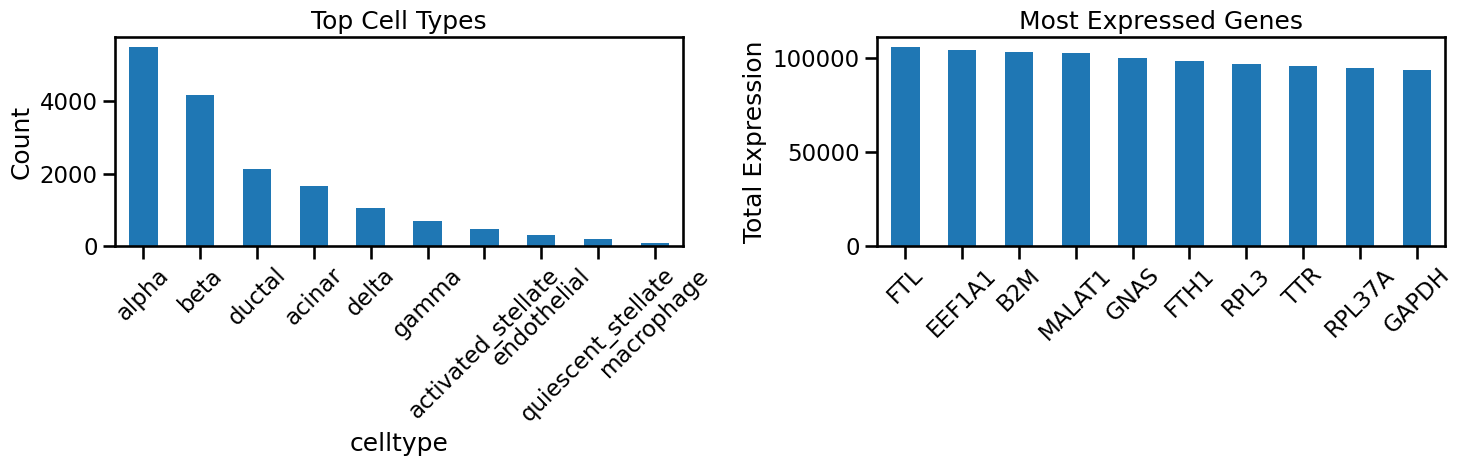

In [9]:
# 1. Most common cell types (assuming 'celltype' is in obs)
n = 10  # specify how many top cell types you want to see
cell_counts = adata.obs['celltype'].value_counts()
print("\n=== Top Cell Types ===")
print(f"Top {n} most common cell types:")
print(cell_counts.head(n))
print(f"\nTotal number of cells: {len(adata.obs)}")

# 2. Gene expression analysis
# Sum expression across cells for each gene
gene_sums = adata.X.sum(axis=0)
if scipy.sparse.issparse(adata.X):
    gene_sums = gene_sums.A1  # Convert to dense array if sparse

# Create DataFrame with gene names and their sums
gene_stats = pd.DataFrame({
    'gene': adata.var_names,
    'total_expression': gene_sums
})
gene_stats = gene_stats.sort_values('total_expression', ascending=False)

print("\n=== Gene Statistics ===")
print(f"Total number of genes: {len(adata.var_names)}")
print(f"\nTop {n} most expressed genes:")
print(gene_stats.head(n))

# 3. Optional: Visualize distributions
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Cell type distribution
cell_counts.head(n).plot(kind='bar', ax=ax1)
ax1.set_title('Top Cell Types')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Gene expression distribution
gene_stats['total_expression'].head(n).plot(kind='bar', ax=ax2)
ax2.set_title('Most Expressed Genes')
ax2.set_ylabel('Total Expression')
ax2.set_xticklabels(gene_stats['gene'].head(n), rotation=45)

plt.tight_layout()
plt.show()

In [12]:
print (adata.layers)

LayersView with keys: counts


In [13]:
# Check the layers
print("Layers in adata:")
print(adata.layers)

# Check if highly variable genes are present
if 'highly_variable' in adata.var.columns:
    print("\nHighly variable genes are present.")
    print(f"Number of highly variable genes: {adata.var['highly_variable'].sum()}")
else:
    print("\nHighly variable genes are not present.")

Layers in adata:
LayersView with keys: counts

Highly variable genes are present.
Number of highly variable genes: 1800


KeyError: 'Could not find key cell_type in .var_names or .obs.columns.'

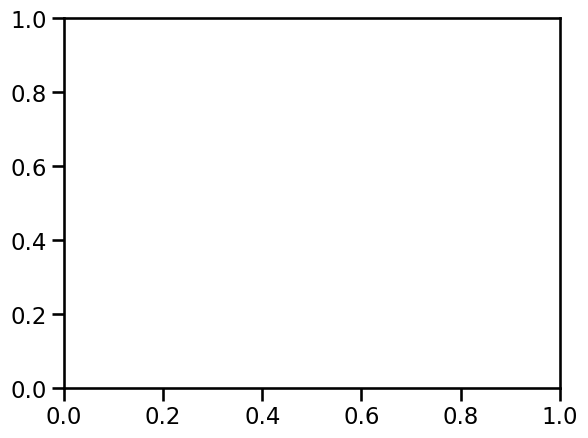

In [12]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Parameters
n_top_hvgs = 20  # Number of top HVGs to show in heatmap
n_top_celltypes = 10  # Number of top cell types to show

# Compute neighbors and UMAP
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)

# Plot UMAP
sc.pl.umap(adata, color='cell_type', title='UMAP of Cell Types')

# Get top cell types
top_celltypes = adata.obs['cell_type'].value_counts().head(n_top_celltypes).index

# Get top HVGs (sorting by normalized dispersion)
hvg_stats = adata.var[adata.var.highly_variable].sort_values('dispersions_norm', ascending=False)
top_hvgs = hvg_stats.index[:n_top_hvgs]

# Create subset of data with only top cell types
adata_subset = adata[adata.obs['cell_type'].isin(top_celltypes)]

# Calculate mean expression for each HVG in each cell type
mean_exp = np.zeros((len(top_celltypes), len(top_hvgs)))
for i, ct in enumerate(top_celltypes):
    mask = adata_subset.obs['cell_type'] == ct
    mean_exp[i, :] = adata_subset[mask].X[:, adata_subset.var_names.isin(top_hvgs)].mean(axis=0)

# Log transform for better visualization
mean_exp = np.log1p(mean_exp)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(mean_exp, 
            xticklabels=top_hvgs,
            yticklabels=top_celltypes,
            cmap='YlOrRd',
            center=0,
            robust=True)

plt.title('Mean Expression of Top Highly Variable Genes Across Cell Types')
plt.xlabel('Highly Variable Genes')
plt.ylabel('Cell Types')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Gene Embeddings with scGPT 

In [15]:
# Set up of the model directory 
model_dir = repo_dir / "scGPT_data" / "scGPT_CP"

print(f"Repository directory: {repo_dir}")
print(f"Model directory: {model_dir}")

Repository directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT
Model directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\scGPT_data\scGPT_CP


In [16]:
import scgpt as scg
import torch
from pathlib import Path

# Set device to CPU
device = torch.device('cpu')

# Define model file path
model_file = Path(model_dir) / "best_model.pt"

# Load model state with CPU mapping
model_state = torch.load(model_file, map_location=device)

# Modify the embed_data function to use the pre-loaded model state
embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
    device='cpu',
    #model_state=model_state  # Pass the pre-loaded model state
)

scGPT - INFO - match 1722/1800 genes in vocabulary of size 60697.


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.